# Code for figures for b) and c)

In [4]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

# Import split and MSELoss. All descent methods.
from Code.utilities import train_test_split, MSELoss_method, plot_test_results
from Code.descent_methods import *
from Code.neural_network import _beta_init, get_neural_network_model

# Import tools from the first project. Feature matrix, sampling and scaling
from Code.project1_tools import feature_matrix_2d, r2_sampling, scale_feature_matrix

# lines used for nice legend, ticker for x and y axis ticks, seaborn for grid search, pandas for nice datastorage. Numpy. jax jit to speed up
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import pandas as pd
import numpy as np
from jax import jit, grad, nn
from tqdm.notebook import tqdm
from matplotlib.colors import LogNorm


# Timing methods
import time as time

# Import the gradient methods. Assign colors for plots comparing them ...
from Code.utilities import ridge_loss_method

methods_dict_list = [{"name"   : "GD",       "method" : GD,           "color" : "C0"},
                     {"name"   : "SGD",      "method" : SGD,          "color" : "C1"},
                     {"name"   : "adagrad",  "method" : SGD_adagrad,  "color" : "C2"},
                     {"name"   : "RMS prop", "method" : SGD_RMS_prop, "color" : "C3"},
                     {"name"   : "adam",     "method" : SGD_adam,     "color" : "C4"}]

# Set the default font size for text elements (e.g., titles, labels)
sns.set() # default from sns is pretties (:
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['font.family'] = 'sans-serif'

# Set filename start. Create the folder if gone
filepath_location = "Figures/bc/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

### Initialisation

In [5]:
### Fix a seed for sampling and initialisation to get consistent results
np.random.seed(41)

# Sample points and split in train and test
num_points = 100
split=0.2
data = r2_sampling(num_points)
x, y, z = data["x"], data["y"], data["z"]

# Features are the scaled coordinates x and y
X = np.array([np.array([x[i][0], y[i][0]]) for i in range(len(x))])
X, means, var = scale_feature_matrix(X)

# Activation functions
activation_funcs = {"ReLu":nn.relu, "Leaky ReLu":nn.leaky_relu, "Sigmoid":nn.sigmoid, "Tanh":nn.tanh}
activation_func_cols = {"ReLu":"C0", "Leaky ReLu":"C1", "Sigmoid":"C2", "Tanh":"C3"}


### Function to perform single run

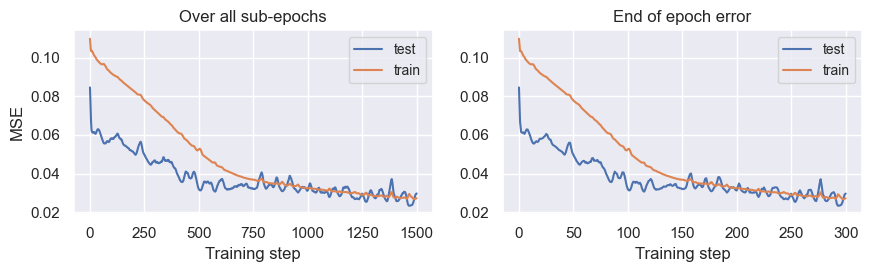

Log run


In [6]:
def single_run(X, z, lr, lam, hidden_layer_num, node_per_hidden, hidden_activation, epochs=300, test_index=None, plot_or_not=False):
    layer_list = [X.shape[1]] + [node_per_hidden]*hidden_layer_num + [1]
    beta0 = _beta_init(layer_list)

    # Create model
    model = jit(get_neural_network_model(hidden_layer_num ,activation=hidden_activation))

    # Create gradient from loss function. Ridge loss lets us use MSE by lam=0
    loss_func = jit(ridge_loss_method(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))

    # MSE loss function for training
    test_func = jit(MSELoss_method(model))

    # Split the dataset.
    X_train, y_train, X_test, y_test, test_index = train_test_split(X, z, 0.2, test_index=test_index)

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=test_func, lr=lr)
    result.update({"test_index":test_index, "model":model, "X_test":X_test, "y_test":y_test})

    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], 5, ylabel="MSE")


    return result

result = single_run(X, z, lr=1e-3, lam=0.00, hidden_layer_num=2, node_per_hidden=10, hidden_activation=nn.sigmoid, plot_or_not=True)
print("Log run")
#TODO LEGG TIL PÅ SLUTTEN ETTER GOOD PARAMS HAR BLITT FUNNET

In [15]:
# TODO ADDE TRENINGSFEIL SOM STIPLET LINJE

def search_lam(savefig=False):
    lr = 0.01
    hidden_layer_num = 3
    node_per_hidden = 5
    
    
    filename = filepath_location + f"lr={lr}_Hidden_layers={hidden_layer_num}_Nodes_per_hidden={node_per_hidden}_lambda_experiment.png"

    lams = np.logspace(-10, 4, num=30)
    test_errs_all = {}
    train_errs_all = {}
    result = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for lam in tqdm(lams):
            #tqdm.write(f"Lambda: {lam}")
            result = single_run(X, z, lr=lr, lam=lam, hidden_layer_num=hidden_layer_num, node_per_hidden=node_per_hidden, hidden_activation=activation_funcs[act_func], test_index=result.get("test_index"))
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])
        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(lams, test_errs, label=act_func, color=activation_func_cols[act_func])
        plt.plot(lams, train_errs, color=activation_func_cols[act_func], linestyle="dotted")

    plt.legend()
    #plt.plot(lams, train_errs)
    plt.title("Final error for varying regularization parameters")
    plt.ylabel("MSE")
    plt.xlabel(r"$\lambda$")
    plt.xscale("log")
    if savefig:
        plt.savefig(filename)  
    plt.show()

    return {"lams":lams, "test_error":test_errs_all, "train_error":train_errs_all}

experiment = search_lam(savefig=True)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

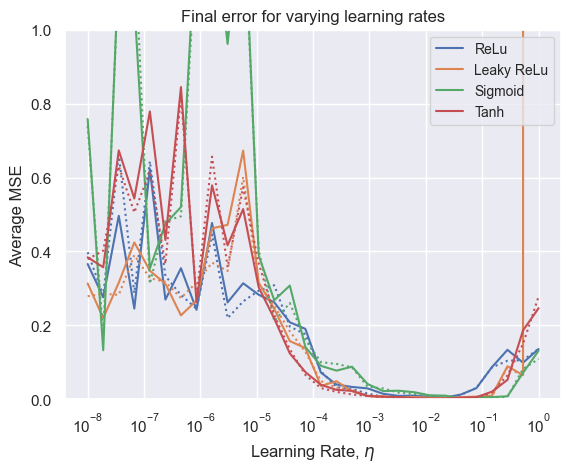

In [ ]:
# TODO LEGG TIL TRAIN ERROR SOM STIPLET LINJE
# TODO KANSKJE AVERAGE ERROR FOR MER STABILITET
def search_lrs(savefig=False, nreps=5):
    lam = 1e-5
    hidden_layer_num = 3
    node_per_hidden = 5
    
    
    filename = filepath_location + f"lambda={lam}_Hidden_layers={hidden_layer_num}_Nodes_per_hidden={node_per_hidden}_nreps={nreps}_lr_experiment.png"

    lrs = np.logspace(-8, 0, num=30)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for lr in tqdm(lrs):
            #tqdm.write(f"Learning rate: {lr}")
            s_test = 0.0
            s_train = 0.0
            for i in range(nreps):
                result = single_run(X, z, lr=lr, lam=lam, hidden_layer_num=hidden_layer_num, node_per_hidden=node_per_hidden, hidden_activation=activation_funcs[act_func])
                s_test += result["test_loss_list"][-1]
                s_train += result["train_loss_list"][-1]
            test_errs.append(s_test/nreps)
            train_errs.append(s_train/nreps)

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(lrs, test_errs, label=act_func, color=activation_func_cols[act_func])
        plt.plot(lrs, train_errs, color=activation_func_cols[act_func], linestyle="dotted")

    plt.legend()
    plt.title("Final error for varying learning rates")
    plt.ylabel("Average MSE")
    plt.ylim(0.0, 1.0)
    plt.xlabel(r"Learning Rate, $\eta$")
    plt.xscale("log")
    if savefig:
        plt.savefig(filename)
    plt.show()

    return {"lrs":lrs, "test_error":test_errs_all, "train_error":train_errs_all}


#learning_rate_exp = search_lrs()
l = search_lrs(savefig=True)

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

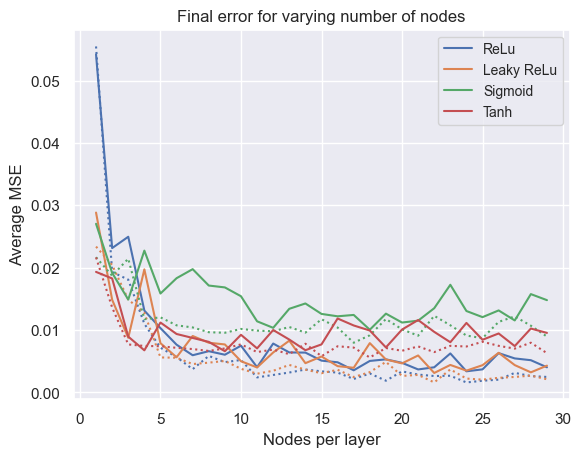

In [ ]:
# TODO KANSKJE AVERAGE ERROR FOR MER STABILITET
# TODO LEGG TIL TRAIN ERROR SOM STIPLET LINJE
def search_hidden_layer_sizes(savefig=False, nreps=5):
    lr = 0.01
    lam = 1e-5
    hidden_layer_num = 1

    filename = filepath_location + f"lr={lr}_lambda={lam}_Hidden_layers={hidden_layer_num}_nreps={nreps}_hidden_layer_size_experiment.png"

    hidden_layer_sizes = np.arange(1, 30)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for hidden_layer_size in tqdm(hidden_layer_sizes):
            #tqdm.write(f"Hidden Layer size: {hidden_layer_size}")
            s_test = 0.0
            s_train = 0.0
            for i in range(nreps):
                result = single_run(X, z, lr=lr, lam=lam, hidden_layer_num=hidden_layer_num, node_per_hidden=hidden_layer_size, hidden_activation=activation_funcs[act_func])
                s_test += result["test_loss_list"][-1]
                s_train += result["train_loss_list"][-1]
            test_errs.append(s_test/nreps)
            train_errs.append(s_train/nreps)

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(hidden_layer_sizes, test_errs, label=act_func, color=activation_func_cols[act_func])
        plt.plot(hidden_layer_sizes, train_errs, color=activation_func_cols[act_func], linestyle="dotted")

    plt.legend()
    plt.title("Final error for varying number of nodes")
    plt.ylabel("Average MSE")
    plt.xlabel("Nodes per layer")
    if savefig:
        plt.savefig(filename)  
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_sizes, "test_error":test_errs_all, "train_error":train_errs_all}


#learning_rate_exp = search_lrs()
l = search_hidden_layer_sizes(savefig=True)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

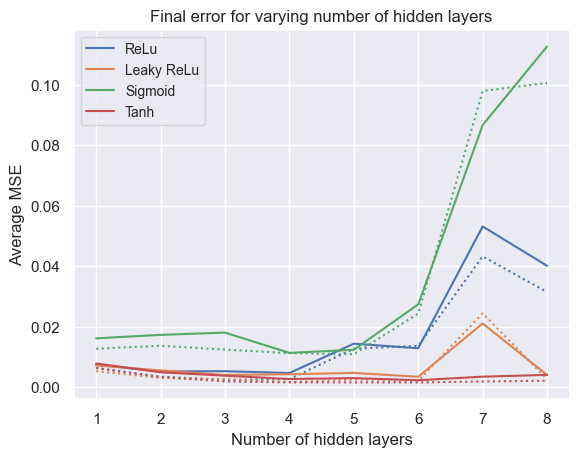

In [ ]:
# TODO Fiks farger
def search_hidden_layer_number(savefig=False, nreps=10):
    lr = 0.01
    lam = 1e-5
    node_per_hidden = 5
    
    
    filename = filepath_location + f"lr={lr}_lambda={lam}_Nodes_per_hidden={node_per_hidden}_nreps={nreps}_hidden_layer_number_experiment.png"

    hidden_layer_numbers = np.arange(1, 9)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for hidden_layer_number in tqdm(hidden_layer_numbers):
            #tqdm.write(f"Hidden Layer number: {hidden_layer_number}")
            s_test = 0.0
            s_train = 0.0
            for i in range(nreps):
                result = single_run(X, z, lr=lr, lam=lam, hidden_layer_num=hidden_layer_number, node_per_hidden=node_per_hidden, hidden_activation=activation_funcs[act_func])
                s_test += result["test_loss_list"][-1]
                s_train += result["train_loss_list"][-1]

            test_errs.append(s_test/nreps)
            train_errs.append(s_train/nreps)

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs
        
        plt.plot(hidden_layer_numbers, test_errs, label=act_func, color=activation_func_cols[act_func])
        plt.plot(hidden_layer_numbers, train_errs, color=activation_func_cols[act_func], linestyle="dotted")

    plt.legend()
    plt.title("Final error for varying number of hidden layers")
    plt.ylabel("Average MSE")
    plt.xlabel("Number of hidden layers")
    if savefig:
        plt.savefig(filename)  
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}


#learning_rate_exp = search_lrs()
l = search_hidden_layer_number(savefig=True)

lr: 1e-06
lr: 1.584893192461114e-05
lr: 0.00025118864315095795
lr: 0.003981071705534969
lr: 0.0630957344480193
lr: 1.0


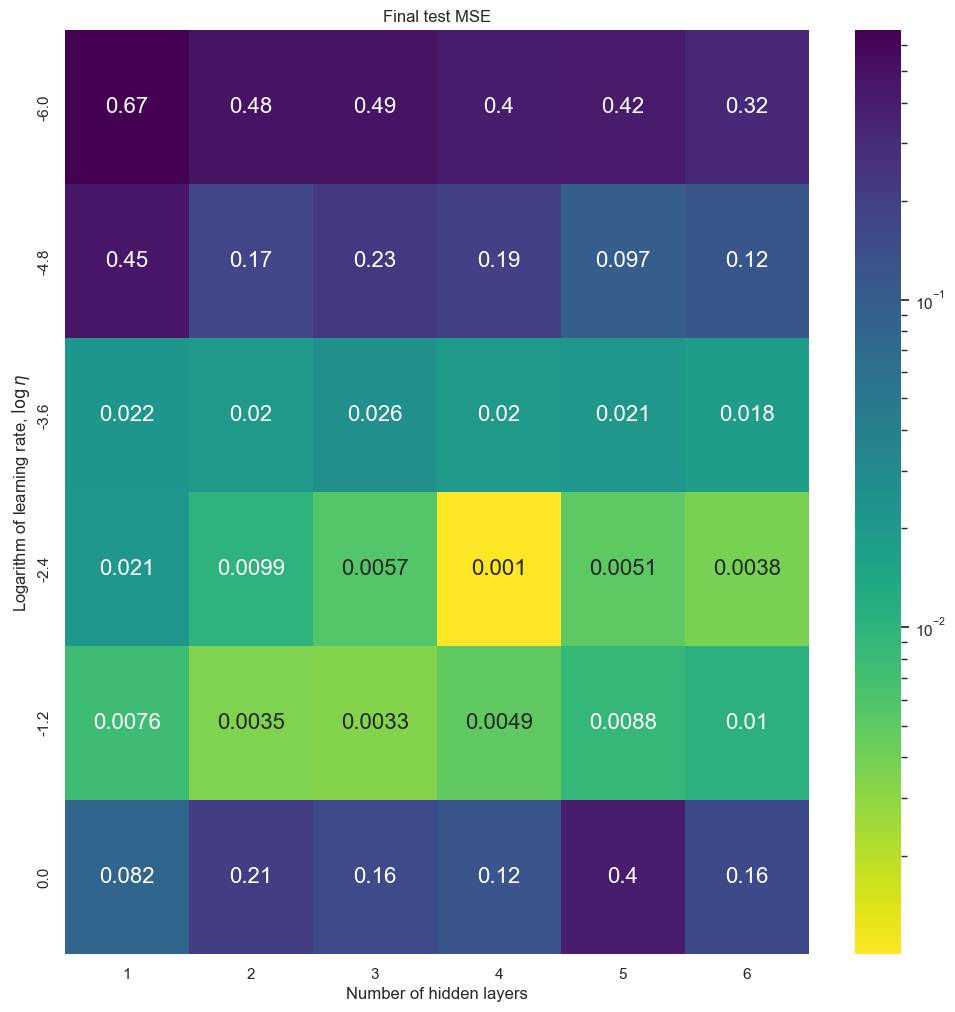

In [8]:
#TODO finpuss
def learning_rate_hidden_layer_grid(savefig=False, nreps=5):
    lam = 1e-5
    node_per_hidden = 5
    hidden_activation = nn.tanh
    hidden_activation_name = "tanh"
    
    n = 6
    
    filename = filepath_location + f"lambda={lam}_Nodes_per_hidden={node_per_hidden}_hidden_activation_func={hidden_activation_name}_nreps={nreps}_lr_hidden_layer_num_grid_experiment.png"

    hidden_layer_numbers = np.arange(1, n + 1)
    lrs = np.logspace(-6, 0, n)

    test_errs_all = np.zeros(shape=(n, n))
    train_errs_all = np.zeros(shape=(n, n))
    for i, lr in enumerate(lrs):
        print(f"lr: {lr}")
        for j, hidden_layer_number in enumerate(hidden_layer_numbers):
            #tqdm.write(f"Learning rate: {lr}, Hidden Layer number: {hidden_layer_number}")
            s_test = 0.0
            s_train = 0.0
            for k in range(nreps):
                result = single_run(X, z, lr=lr, lam=lam, hidden_layer_num=hidden_layer_number, node_per_hidden=node_per_hidden, hidden_activation=hidden_activation)
                s_test += result["test_loss_list"][-1]
                s_train += result["train_loss_list"][-1]

            test_errs_all[i, j] = s_test/nreps
            train_errs_all[i, j] = s_train/nreps


    # Make sns heatmap
    fig, ax = plt.subplots(figsize = (12, 12))
    sns.heatmap(test_errs_all, annot=True, ax=ax, cmap="viridis_r", cbar=True, norm="log")

    # Title
    ax.set_title("Final test MSE")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Logarithm of learning rate, $\log{\eta}$")

    ax.set_yticklabels(np.round(np.log10(lrs), 2))
    ax.set_xticklabels((hidden_layer_numbers))

    if savefig:
        fig.savefig(filename)

    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}


r= learning_rate_hidden_layer_grid(savefig=True)

## Optimal arhitecture

nodes per layer: 1
nodes per layer: 4
nodes per layer: 7
nodes per layer: 10
nodes per layer: 13
nodes per layer: 16


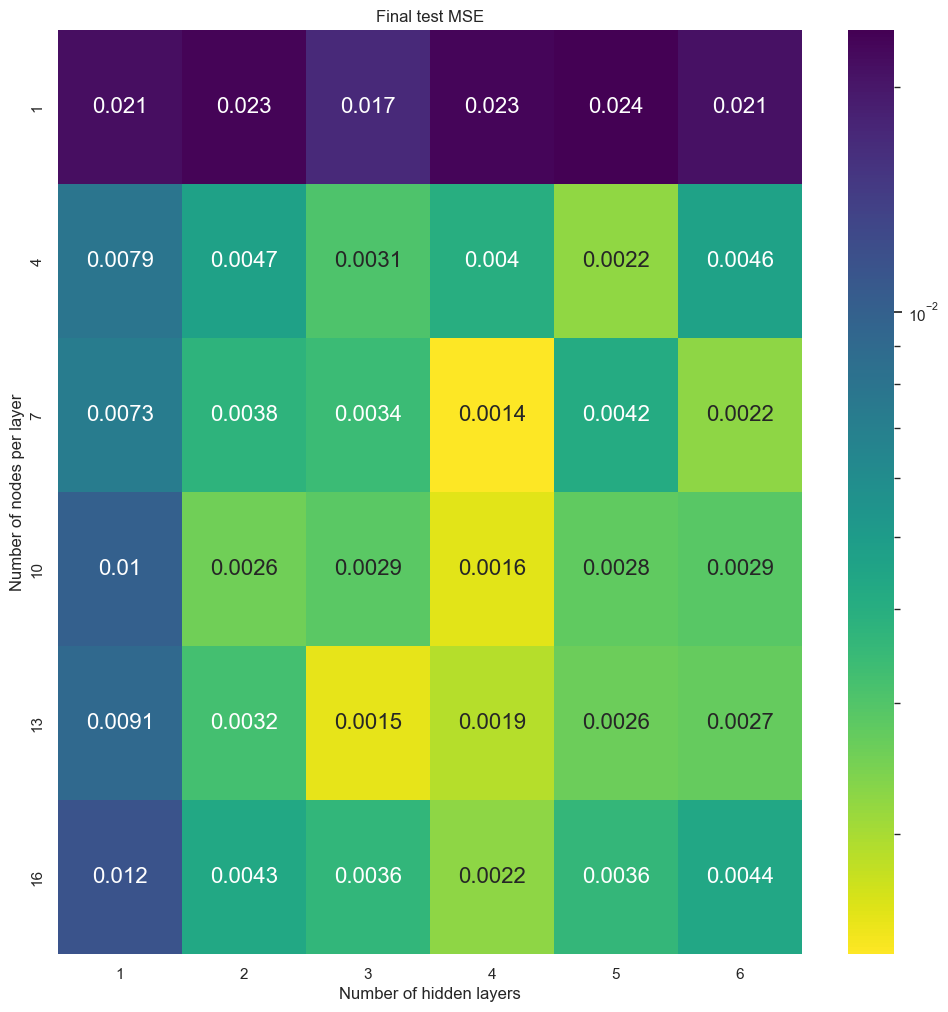

In [10]:
#TODO finpuss
def hidden_node_hidden_layer_grid(savefig=False, nreps=5):
    lam = 1e-5
    lr = 0.01
    hidden_activation = nn.tanh
    hidden_activation_name = "tanh"
    
    n = 6
    
    filename = filepath_location + f"lr={lr}_lambda={lam}_hidden_activation_func={hidden_activation_name}_nreps={nreps}__hidden_layer_num_grid_experiment.png"

    hidden_layer_numbers = np.arange(1, n + 1)
    nodes_per_layer_list = np.arange(1, 19, 19//n)

    test_errs_all = np.zeros(shape=(n, n))
    train_errs_all = np.zeros(shape=(n, n))
    for i, nodes_per_layer in enumerate(nodes_per_layer_list):
        print(f"nodes per layer: {nodes_per_layer}")
        for j, hidden_layer_number in enumerate(hidden_layer_numbers):
            #tqdm.write(f"Learning rate: {lr}, Hidden Layer number: {hidden_layer_number}")
            s_test = 0.0
            s_train = 0.0
            for k in range(nreps):
                result = single_run(X, z, lr=lr, lam=lam, hidden_layer_num=hidden_layer_number, node_per_hidden=nodes_per_layer, hidden_activation=hidden_activation)
                s_test += result["test_loss_list"][-1]
                s_train += result["train_loss_list"][-1]

            test_errs_all[i, j] = s_test/nreps
            train_errs_all[i, j] = s_train/nreps


    # Make sns heatmap
    fig, ax = plt.subplots(figsize = (12, 12))
    sns.heatmap(test_errs_all, annot=True, ax=ax, cmap="viridis_r", cbar=True, norm="log")

    # Title
    ax.set_title("Final test MSE")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Number of nodes per layer")

    ax.set_yticklabels(nodes_per_layer_list)
    ax.set_xticklabels(hidden_layer_numbers)
    

    if savefig:
        fig.savefig(filename)
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}


r= hidden_node_hidden_layer_grid(savefig=True)

# Plotting the result of the best prediction

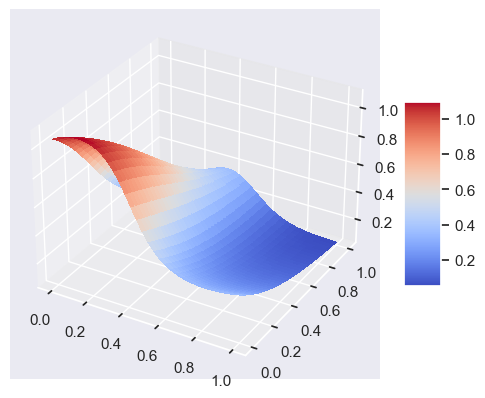

In [55]:
import matplotlib.cm as cm

def plot_surface(x,y,z, filename=None):

    # Init figure
    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    if filename:
        plt.savefig(filename)

    plt.show()

def plot_neural_network_franke_prediction(beta_dict, means, var, filename=None):

    # Number of points to use
    num_plot = 101

    # Make data.
    x = np.linspace(0, 1, num_plot).reshape((num_plot, 1))
    y = np.linspace(0, 1, num_plot).reshape((num_plot, 1))

    x_mesh = np.zeros(shape=(num_plot*num_plot, 1))
    y_mesh = np.zeros(shape=(num_plot*num_plot, 1))

    for i in range(num_plot):
        for j in range(num_plot):
            x_mesh[j*num_plot + i] = x[i, 0]
            y_mesh[j*num_plot + i] = y[j, 0]
    
    # Feature matrix of points to plot
    X = (np.array([np.array([x[i][0], y[j][0]]) for i in range(len(x)) for j in range(len(y))]) - means) / np.sqrt(var)
    
    # Make prediction
    z = np.array([s[0] for s in model(beta_dict, X)])
    # Reshaoe
    x_mesh = x_mesh.reshape(num_plot, num_plot)
    y_mesh = y_mesh.reshape(num_plot, num_plot)
    z_mesh = z.reshape(num_plot, num_plot)

    # Plot surface
    plot_surface(x_mesh,y_mesh,z_mesh, filename=filename)

### Fix a seed for sampling and initialisation to get consistent results
np.random.seed(41)

# Sample points and split in train and test
num_points = 10000
split=0.2
data = r2_sampling(num_points)
x, y, z = data["x"], data["y"], data["z"]

# Features are the scaled coordinates x and y
X = np.array([np.array([x[i][0], y[i][0]]) for i in range(len(x))])
X, means, var = scale_feature_matrix(X)


N_hidden = 7
node_hidden = 12
activation = nn.sigmoid

model = get_neural_network_model(N_hidden, activation=activation)
result = single_run(X, z, lr=0.01, lam=0.00000, hidden_layer_num=N_hidden, node_per_hidden=node_hidden, hidden_activation=activation, plot_or_not=False)
plot_neural_network_franke_prediction(result["beta_final"], means, var)

In [52]:
print(result["test_loss_list"][-1])

0.0023922618
